# Libraries and plotting

In [1]:
# default libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
import time
import math

In [2]:
# plotting configuration
sns.set(style = 'darkgrid',
        font_scale = 1.4,
        rc = {"lines.linewidth": 2,
          "figure.figsize": (12, 8)})

sns.set_palette('Set2')

In [81]:
from tools import get_exponential_bins,compute_quantile_hist_data, alternative_quantile_hist_data
from data_gen import generate_raw_data, get_binned_data_client_level,\
get_binned_data_cookie_bucket_level

# Simulations

In [80]:
import importlib,sys
importlib.reload(sys.modules['tools'])

<module 'tools' from '/Users/apodkopaev/Desktop/code/tools.py'>

In [82]:
# generate raw data
raw_data = generate_raw_data(number_of_users = 5000)

# compute bin boundaries
bins_boundaries = get_exponential_bins(10, 600000, 100)

# bin raw data
binned_data = get_binned_data_client_level(raw_data, bins_boundaries)

In [83]:
number_of_buckets=20

In [84]:
# compute cookie buckets for the binned data
binned_data['Bucket ID'] = (
    binned_data['Client ID'] % number_of_buckets).astype('int')

# compute cookie buckets for the raw data
raw_data['Bucket ID'] = (
    raw_data['Client ID'] % number_of_buckets).astype('int')

In [85]:
# compute histogram data / total counts within each bucket
bucket_data = binned_data.groupby('Bucket ID').sum()
bucket_data = bucket_data.drop(axis=1, columns=['Client ID'])

# number of histogram bins
num_of_bins=len(bins_boundaries)-1

# compute tuples of endpoints for each interval for histogram bins
bins_tuples = [(bins_boundaries[i-1], bins_boundaries[i]) for i in range(1, num_of_bins+1)]

# compute midpoints of each bin
bin_midpoints = [np.mean(bins_tuples[i]) for i in range(num_of_bins)]

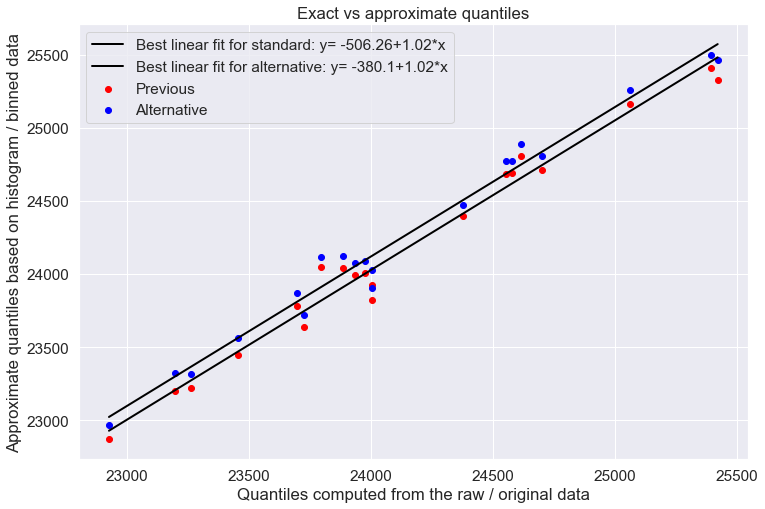

In [89]:
cur_quantile = 0.95

# obtain exact and approximate quantiles for a given level
appr_quantiles_alt = np.array([alternative_quantile_hist_data(bucket_data.loc[i].values, bins_tuples, quantile=cur_quantile,midpoints_comp='log') for i in range(number_of_buckets)])

appr_quantiles = np.array([compute_quantile_hist_data(bucket_data.loc[i].values, bins_tuples, quantile=cur_quantile) for i in range(number_of_buckets)])

exact_quantiles = raw_data.groupby('Bucket ID').quantile(cur_quantile)['Metric Value'].values

# fit linear regression
reg_1 = LinearRegression().fit(exact_quantiles.reshape(-1,1), appr_quantiles)

reg_2 = LinearRegression().fit(exact_quantiles.reshape(-1,1), appr_quantiles_alt)

# plot the results
x_range = np.linspace(min(exact_quantiles), max(exact_quantiles))
plt.scatter(exact_quantiles,appr_quantiles,color='red', label='Previous')
plt.scatter(exact_quantiles,appr_quantiles_alt, color='blue',label='Alternative')
plt.plot(x_range ,reg_1.intercept_ + reg_1.coef_ * x_range, color='black', label='Best linear fit for standard: y= ' + 
    str(reg_1.intercept_.round(2)) +'+' +str(reg_1.coef_.round(2)[0])+"*x")
plt.plot(x_range ,reg_2.intercept_ + reg_2.coef_ * x_range, color='black', label='Best linear fit for alternative: y= ' + 
    str(reg_2.intercept_.round(2)) +'+' +str(reg_2.coef_.round(2)[0])+"*x")
plt.ylabel('Approximate quantiles based on histogram / binned data')
plt.xlabel('Quantiles computed from the raw / original data')
plt.title('Exact vs approximate quantiles')
plt.legend()
plt.show()

## Relative error in approximation (median, 95th, 99th)

In [119]:
approx_error_50=list()
approx_error_95=list()
approx_error_99=list()

number_of_obs = list()

In [120]:
number_of_clients = np.linspace(50, 30000, 100)

In [122]:
for cur_number_of_clients in number_of_clients:
    # generate raw data
    raw_data = generate_raw_data(number_of_users =int(cur_number_of_clients))
    number_of_obs+=[raw_data.shape[0]]

    # bin raw data
    binned_data = get_binned_data_client_level(raw_data, bins_boundaries)# generate raw data

    # compute cookie buckets for the binned data
    binned_data['Bucket ID'] = (
        binned_data['Client ID'] % number_of_buckets).astype('int')

    # compute cookie buckets for the raw data
    raw_data['Bucket ID'] = (
        raw_data['Client ID'] % number_of_buckets).astype('int')

    # compute histogram data / total counts within each bucket
    bucket_data = binned_data.groupby('Bucket ID').sum()
    bucket_data = bucket_data.drop(axis=1, columns=['Client ID'])

    # number of histogram bins
    num_of_bins=len(bins_boundaries)

    # compute tuples of endpoints for each interval for histogram bins
    bins_tuples = [(0, bins_boundaries[0])] + [(bins_boundaries[i-1], bins_boundaries[i]) for i in range(1, num_of_bins)]

    # compute midpoints of each bin
    bin_midpoints = [np.mean(bins_tuples[i]) for i in range(num_of_bins)]

    # median 
    appr_quantiles = np.array([compute_quantile_hist_data(bucket_data.loc[i].values, bins_tuples, quantile=0.5) for i in range(number_of_buckets)])
    exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.5)['Metric Value'].values
    approx_error_50+= [np.linalg.norm(exact_quantiles-appr_quantiles)/np.linalg.norm(exact_quantiles)]
    
    # 95th
    appr_quantiles = np.array([compute_quantile_hist_data(bucket_data.loc[i].values, bins_tuples, quantile=0.95) for i in range(number_of_buckets)])
    exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.95)['Metric Value'].values
    approx_error_95+= [np.linalg.norm(exact_quantiles-appr_quantiles)/np.linalg.norm(exact_quantiles)]
    
    # 99th
    appr_quantiles = np.array([compute_quantile_hist_data(bucket_data.loc[i].values, bins_tuples, quantile=0.99) for i in range(number_of_buckets)])
    exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.99)['Metric Value'].values
    approx_error_99+= [np.linalg.norm(exact_quantiles-appr_quantiles)/np.linalg.norm(exact_quantiles)]

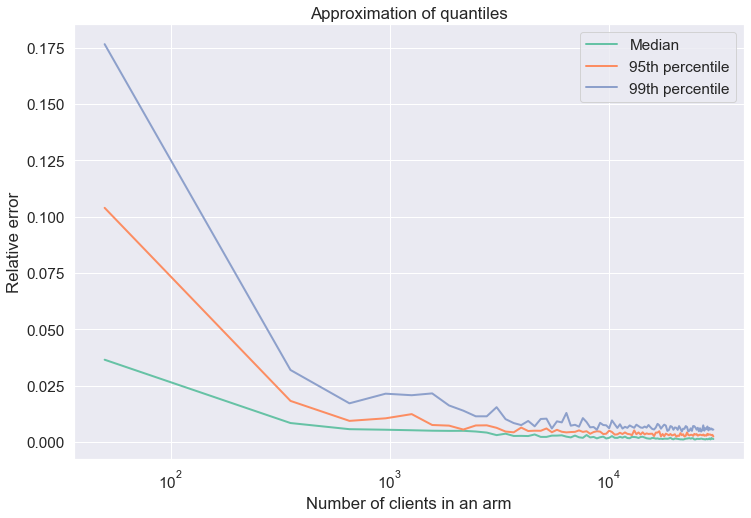

In [67]:
plt.plot(number_of_clients, approx_error_50, label='Median', )
plt.plot(number_of_clients, approx_error_95, label='95th percentile')
plt.plot(number_of_clients, approx_error_99, label='99th percentile')
plt.xscale('log')
plt.ylabel('Relative error')
plt.xlabel('Number of clients in an arm')
plt.title('Approximation of quantiles')
plt.legend()
plt.show()

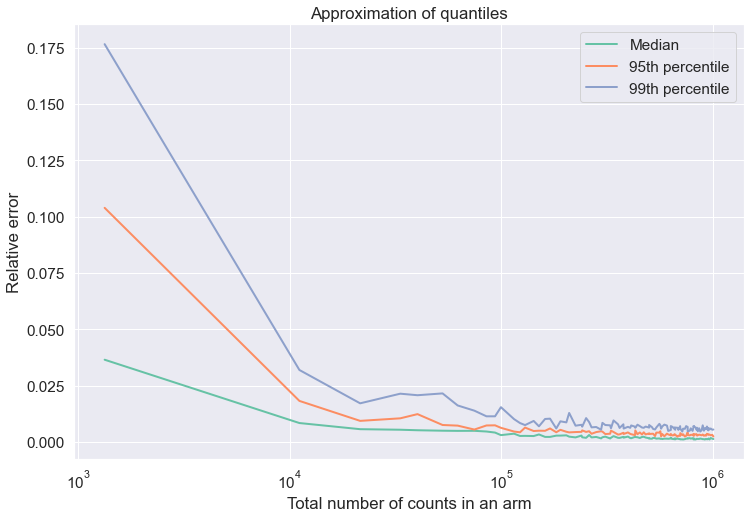

In [66]:
plt.plot(number_of_obs, approx_error_50, label='Median', )
plt.plot(number_of_obs, approx_error_95, label='95th percentile')
plt.plot(number_of_obs, approx_error_99, label='99th percentile')
plt.xscale('log')
plt.ylabel('Relative error')
plt.xlabel('Total number of counts in an arm')
plt.title('Approximation of quantiles')
plt.legend()
plt.show()

### number of users on a log-scale

In [4]:
log_number_of_clients = np.logspace(1.69,4.7, 100)

In [5]:
log_approx_error_50=list()
log_approx_error_95=list()
log_approx_error_99=list()

log_number_of_obs = list()

In [79]:
for cur_number_of_clients in log_number_of_clients:
    # generate raw data
    raw_data = generate_raw_data(number_of_users =int(cur_number_of_clients))
    log_number_of_obs+=[raw_data.shape[0]]

    # bin raw data
    binned_data = get_binned_data(raw_data, bins_boundaries)

    # compute cookie buckets for the binned data
    binned_data['Bucket ID'] = (
        binned_data['Client ID'] % number_of_buckets).astype('int')

    # compute cookie buckets for the raw data
    raw_data['Bucket ID'] = (
        raw_data['Client ID'] % number_of_buckets).astype('int')

    # compute histogram data / total counts within each bucket
    bucket_data = binned_data.groupby('Bucket ID').sum()
    bucket_data = bucket_data.drop(axis=1, columns=['Client ID'])

    # number of histogram bins
    num_of_bins=len(bins_boundaries)

    # compute tuples of endpoints for each interval for histogram bins
    bins_tuples =  [(bins_boundaries[i-1], bins_boundaries[i]) for i in range(1, num_of_bins)]

    # compute midpoints of each bin
    bin_midpoints = [np.mean(bins_tuples[i]) for i in range(num_of_bins)]

    # median 
    appr_quantiles = np.array([compute_quantile_hist_data(bucket_data.loc[i].values, bins_tuples, quantile=0.5) for i in range(number_of_buckets)])
    exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.5)['Metric Value'].values
    log_approx_error_50+= [np.linalg.norm(exact_quantiles-appr_quantiles)/np.linalg.norm(exact_quantiles)]
    
    # 95th
    appr_quantiles = np.array([compute_quantile_hist_data(bucket_data.loc[i].values, bins_tuples, quantile=0.95) for i in range(number_of_buckets)])
    exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.95)['Metric Value'].values
    log_approx_error_95+= [np.linalg.norm(exact_quantiles-appr_quantiles)/np.linalg.norm(exact_quantiles)]
    
    # 99th
    appr_quantiles = np.array([compute_quantile_hist_data(bucket_data.loc[i].values, bins_tuples, quantile=0.99) for i in range(number_of_buckets)])
    exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.99)['Metric Value'].values
    log_approx_error_99+= [np.linalg.norm(exact_quantiles-appr_quantiles)/np.linalg.norm(exact_quantiles)]

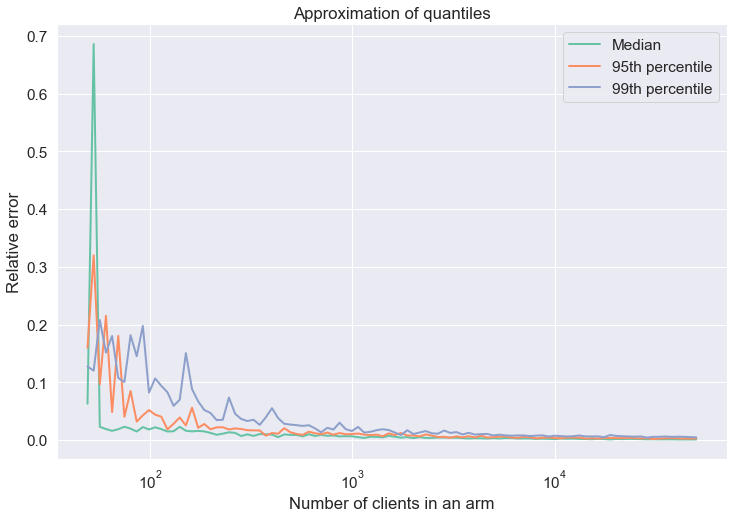

In [86]:
plt.plot(log_number_of_clients, log_approx_error_50, label='Median', )
plt.plot(log_number_of_clients, log_approx_error_95, label='95th percentile')
plt.plot(log_number_of_clients, log_approx_error_99, label='99th percentile')
plt.xscale('log')
plt.ylabel('Relative error')
plt.xlabel('Number of clients in an arm')
plt.title('Approximation of quantiles')
plt.legend()
plt.show()

## Considering different measure of relative error

### single simulation

In [50]:
# compute bin boundaries
bins_boundaries = get_exponential_bins(10, 600000, 100)


In [51]:
log_number_of_clients = np.logspace(1.69,4.7, 50)

In [52]:
number_of_buckets=1 # everything is mapped into the same bucket

In [53]:
log_approx_error_50=list()
log_approx_error_95=list()
log_approx_error_99=list()

log_number_of_obs = list()

In [ ]:
from scipy.stats import norm
import statsmodels.distributions.empirical_distribution as edf
from scipy.interpolate import interp1d
import pdb

In [ ]:
sample_edf = edf.ECDF(bootstrap_est)
slope_changes = sorted(set(bootstrap_est))

sample_edf_values_at_slope_changes = [
    sample_edf(item) for item in slope_changes]
inverted_edf = interp1d(sample_edf_values_at_slope_changes, slope_changes)


In [54]:
for cur_number_of_clients in log_number_of_clients:
    # generate raw data
    raw_data = generate_raw_data(number_of_users =int(cur_number_of_clients))
    log_number_of_obs+=[raw_data.shape[0]]

    # bin raw data
    bucket_data = get_binned_data_cookie_bucket_level(raw_data, number_of_buckets, bins_boundaries)

    # compute cookie buckets for the raw data
    raw_data['Bucket ID'] = (
        raw_data['Client ID'] % number_of_buckets).astype('int')

    # number of histogram bins
    num_of_bins=len(bins_boundaries)-1

    # compute tuples of endpoints for each interval for histogram bins
    bins_tuples = [(bins_boundaries[i-1], bins_boundaries[i]) for i in range(1, num_of_bins+1)]

    # compute midpoints of each bin
    bin_midpoints = [np.mean(bins_tuples[i]) for i in range(num_of_bins)]

    # median 
    appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.5) 
    exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.5)['Metric Value'].values
    log_approx_error_50+= [abs(exact_quantiles-appr_quantiles)/exact_quantiles]
    
    # 95th
    appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.95) 
    exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.95)['Metric Value'].values
    log_approx_error_95+= [abs(exact_quantiles-appr_quantiles)/exact_quantiles]
    
    # 99th
    appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.99)
    exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.99)['Metric Value'].values
    log_approx_error_99+= [abs(exact_quantiles-appr_quantiles)/exact_quantiles]

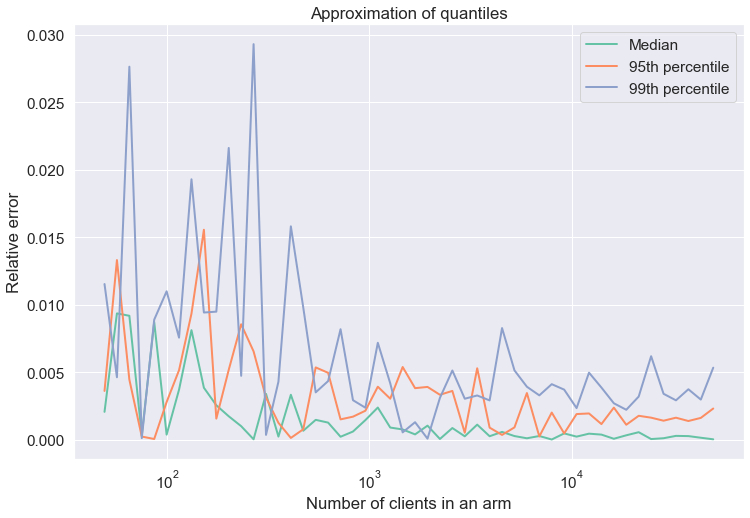

In [55]:
plt.plot(log_number_of_clients, log_approx_error_50, label='Median')
plt.plot(log_number_of_clients, log_approx_error_95, label='95th percentile')
plt.plot(log_number_of_clients, log_approx_error_99, label='99th percentile')
plt.xscale('log')
plt.ylabel('Relative error')
plt.xlabel('Number of clients in an arm')
plt.title('Approximation of quantiles')
plt.legend()
plt.show()

### aggregation over multiple simulations

In [116]:
log_number_of_clients = np.logspace(1.7,4.2, 20)

In [117]:
log_number_of_clients

array([   50.11872336,    67.85454573,    91.86665318,   124.37607347,
         168.38980324,   227.97894356,   308.65526124,   417.88100603,
         565.75914015,   765.96782348,  1037.02559087,  1404.00424555,
        1900.8479047 ,  2573.51270002,  3484.21754354,  4717.19913821,
        6386.50354965,  8646.5350295 , 11706.33781617, 15848.93192461])

In [118]:
log_approx_error_50_alt=list()
log_approx_error_95_alt=list()
log_approx_error_99_alt=list()

log_number_of_obs_alt = list()

In [119]:
number_of_sims_per_iteration = 100

In [120]:
number_of_buckets=1

In [121]:
for cur_number_of_clients in log_number_of_clients:
    cur_med = list()
    cur_95 = list()
    cur_99 = list()
    # number of histogram bins
    num_of_bins=len(bins_boundaries)-1

    # compute tuples of endpoints for each interval for histogram bins
    bins_tuples =  [(bins_boundaries[i-1], bins_boundaries[i]) for i in range(1, num_of_bins+1)]

    # compute midpoints of each bin
    bin_midpoints = [np.mean(bins_tuples[i]) for i in range(num_of_bins)]
    for cur_sim in range(number_of_sims_per_iteration):
        # generate raw data
        raw_data = generate_raw_data(number_of_users =int(cur_number_of_clients))
        log_number_of_obs+=[raw_data.shape[0]]

        # bin raw data
        bucket_data = get_binned_data_cookie_bucket_level(raw_data, number_of_buckets, bins_boundaries)

        # compute cookie buckets for the raw data
        raw_data['Bucket ID'] = (
            raw_data['Client ID'] % number_of_buckets).astype('int')

        # median 
        appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.5) 
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.5)['Metric Value'].values
        cur_med += [abs(exact_quantiles-appr_quantiles)/exact_quantiles]
        
        # 95th
        appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.95) 
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.95)['Metric Value'].values
        cur_95 += [abs(exact_quantiles-appr_quantiles)/exact_quantiles]
        
        # 99th
        appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.99)
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.99)['Metric Value'].values
        cur_99 += [abs(exact_quantiles-appr_quantiles)/exact_quantiles]
    
    log_approx_error_50_alt += [np.mean(cur_med)]
    log_approx_error_95_alt += [np.mean(cur_95)]
    log_approx_error_99_alt += [np.mean(cur_99)]
        
        

In [130]:
log_approx_error_50_prev=list()
log_approx_error_95_prev=list()
log_approx_error_99_prev=list()

log_number_of_obs_prev = list()

In [131]:
# number of histogram bins
num_of_bins=len(bins_boundaries)-1

# compute tuples of endpoints for each interval for histogram bins
bins_tuples =  [(bins_boundaries[i-1], bins_boundaries[i]) for i in range(1, num_of_bins+1)]

# compute midpoints of each bin
bin_midpoints = [np.mean(bins_tuples[i]) for i in range(num_of_bins)]
for cur_number_of_clients in log_number_of_clients:
    cur_med = list()
    cur_95 = list()
    cur_99 = list()
    
    for cur_sim in range(number_of_sims_per_iteration):
        # generate raw data
        raw_data = generate_raw_data(number_of_users =int(cur_number_of_clients))
        log_number_of_obs+=[raw_data.shape[0]]

        # bin raw data
        bucket_data = get_binned_data_cookie_bucket_level(raw_data, number_of_buckets, bins_boundaries)

        # compute cookie buckets for the raw data
        raw_data['Bucket ID'] = (
            raw_data['Client ID'] % number_of_buckets).astype('int')

        # number of histogram bins
        num_of_bins=len(bins_boundaries)-1

        # compute tuples of endpoints for each interval for histogram bins
        bins_tuples = [(bins_boundaries[i-1], bins_boundaries[i]) for i in range(1, num_of_bins+1)]

        # compute midpoints of each bin
        bin_midpoints = [np.mean(bins_tuples[i]) for i in range(num_of_bins)]

        # median 
        appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.5) 
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.5)['Metric Value'].values
        cur_med+= [abs(exact_quantiles-appr_quantiles)/exact_quantiles]

        # 95th
        appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.95) 
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.95)['Metric Value'].values
        cur_95+= [abs(exact_quantiles-appr_quantiles)/exact_quantiles]

        # 99th
        appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.99)
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.99)['Metric Value'].values
        cur_99+= [abs(exact_quantiles-appr_quantiles)/exact_quantiles]
    log_approx_error_50_prev += [np.mean(cur_med)]
    log_approx_error_95_prev += [np.mean(cur_95)]
    log_approx_error_99_prev += [np.mean(cur_99)]
    

In [124]:
log_approx_error_50_alt_log=list()
log_approx_error_95_alt_log=list()
log_approx_error_99_alt_log=list()

log_number_of_obs_alt_log = list()

In [125]:
for cur_number_of_clients in log_number_of_clients:
    cur_med = list()
    cur_95 = list()
    cur_99 = list()
    # number of histogram bins
    num_of_bins=len(bins_boundaries)-1

    # compute tuples of endpoints for each interval for histogram bins
    bins_tuples =  [(bins_boundaries[i-1], bins_boundaries[i]) for i in range(1, num_of_bins+1)]

    # compute midpoints of each bin
    bin_midpoints = [np.mean(bins_tuples[i]) for i in range(num_of_bins)]
    for cur_sim in range(number_of_sims_per_iteration):
        # generate raw data
        raw_data = generate_raw_data(number_of_users =int(cur_number_of_clients))
        log_number_of_obs+=[raw_data.shape[0]]

        # bin raw data
        bucket_data = get_binned_data_cookie_bucket_level(raw_data, number_of_buckets, bins_boundaries)

        # compute cookie buckets for the raw data
        raw_data['Bucket ID'] = (
            raw_data['Client ID'] % number_of_buckets).astype('int')

        # median 
        appr_quantiles = alternative_quantile_hist_data(bucket_data.values.ravel(), bins_tuples, quantile=0.5,midpoints_comp='log') 
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.5)['Metric Value'].values
        cur_med += [abs(exact_quantiles-appr_quantiles)/exact_quantiles]
        
        # 95th
        appr_quantiles = alternative_quantile_hist_data(bucket_data.values.ravel(), bins_tuples, quantile=0.95,midpoints_comp='log') 
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.95)['Metric Value'].values
        cur_95 += [abs(exact_quantiles-appr_quantiles)/exact_quantiles]
        
        # 99th
        appr_quantiles = alternative_quantile_hist_data(bucket_data.values.ravel(), bins_tuples, quantile=0.99,midpoints_comp='log')
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.99)['Metric Value'].values
        cur_99 += [abs(exact_quantiles-appr_quantiles)/exact_quantiles]
    
    log_approx_error_50_alt_log += [np.mean(cur_med)]
    log_approx_error_95_alt_log += [np.mean(cur_95)]
    log_approx_error_99_alt_log += [np.mean(cur_99)]
        
        

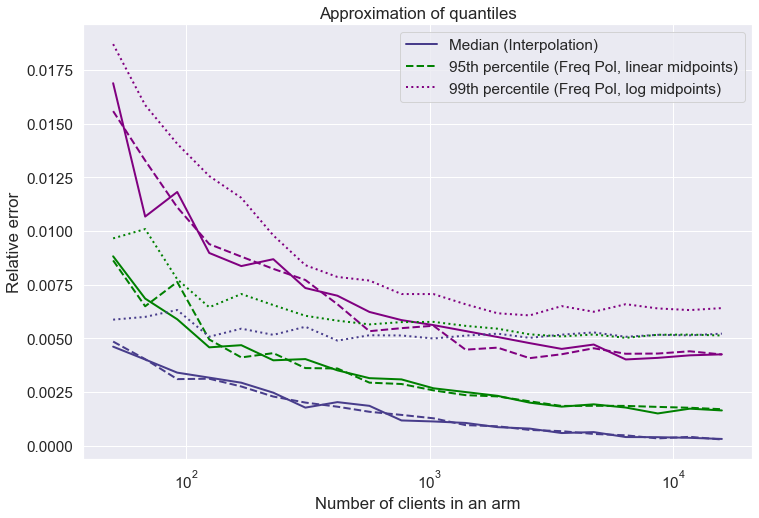

In [144]:
plt.plot(log_number_of_clients, log_approx_error_50_prev, color='darkslateblue',label='Median (Interpolation)')
plt.plot(log_number_of_clients, log_approx_error_95_prev, color='green')
plt.plot(log_number_of_clients, log_approx_error_99_prev, color='purple')
plt.plot(log_number_of_clients, log_approx_error_50_alt, color='darkslateblue',linestyle='dashed')
plt.plot(log_number_of_clients, log_approx_error_95_alt, color='green',linestyle='dashed',label='95th percentile (Freq Pol, linear midpoints)')
plt.plot(log_number_of_clients, log_approx_error_99_alt,color='purple', linestyle='dashed')
plt.plot(log_number_of_clients, log_approx_error_50_alt_log, color='darkslateblue',linestyle='dotted')
plt.plot(log_number_of_clients, log_approx_error_95_alt_log, color='green',linestyle='dotted')
plt.plot(log_number_of_clients, log_approx_error_99_alt_log, color='purple',linestyle='dotted',label='99th percentile (Freq Pol, log midpoints)')
plt.xscale('log')
plt.ylabel('Relative error')
plt.xlabel('Number of clients in an arm')
plt.title('Approximation of quantiles')
plt.legend()
plt.show()

## Change bin boundaries

In [156]:
max(raw_data['Metric Value'].values)

122732.06144432329

In [157]:
bins_boundaries = get_exponential_bins(10,130000, 100)

In [158]:
bins_boundaries

array([         0,         10,         11,         12,         13,
               14,         15,         17,         19,         21,
               23,         25,         28,         31,         34,
               37,         41,         45,         50,         55,
               61,         67,         74,         82,         90,
               99,        109,        120,        132,        145,
              160,        176,        194,        214,        236,
              260,        287,        316,        348,        383,
              422,        465,        512,        564,        622,
              685,        755,        832,        917,       1011,
             1114,       1228,       1353,       1491,       1643,
             1811,       1996,       2200,       2424,       2671,
             2943,       3243,       3574,       3939,       4341,
             4784,       5272,       5810,       6403,       7056,
             7776,       8569,       9443,      10406,      11

In [159]:
log_approx_error_50_alt=list()
log_approx_error_95_alt=list()
log_approx_error_99_alt=list()

log_number_of_obs_alt = list()

In [160]:
number_of_buckets=1

In [161]:
for cur_number_of_clients in log_number_of_clients:
    cur_med = list()
    cur_95 = list()
    cur_99 = list()
    # number of histogram bins
    num_of_bins=len(bins_boundaries)-1

    # compute tuples of endpoints for each interval for histogram bins
    bins_tuples =  [(bins_boundaries[i-1], bins_boundaries[i]) for i in range(1, num_of_bins+1)]

    # compute midpoints of each bin
    bin_midpoints = [np.mean(bins_tuples[i]) for i in range(num_of_bins)]
    for cur_sim in range(number_of_sims_per_iteration):
        # generate raw data
        raw_data = generate_raw_data(number_of_users =int(cur_number_of_clients))
        log_number_of_obs+=[raw_data.shape[0]]

        # bin raw data
        bucket_data = get_binned_data_cookie_bucket_level(raw_data, number_of_buckets, bins_boundaries)

        # compute cookie buckets for the raw data
        raw_data['Bucket ID'] = (
            raw_data['Client ID'] % number_of_buckets).astype('int')

        # median 
        appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.5) 
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.5)['Metric Value'].values
        cur_med += [abs(exact_quantiles-appr_quantiles)/exact_quantiles]
        
        # 95th
        appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.95) 
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.95)['Metric Value'].values
        cur_95 += [abs(exact_quantiles-appr_quantiles)/exact_quantiles]
        
        # 99th
        appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.99)
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.99)['Metric Value'].values
        cur_99 += [abs(exact_quantiles-appr_quantiles)/exact_quantiles]
    
    log_approx_error_50_alt += [np.mean(cur_med)]
    log_approx_error_95_alt += [np.mean(cur_95)]
    log_approx_error_99_alt += [np.mean(cur_99)]
        
        

In [162]:
log_approx_error_50_prev=list()
log_approx_error_95_prev=list()
log_approx_error_99_prev=list()

log_number_of_obs_prev = list()

In [163]:
# number of histogram bins
num_of_bins=len(bins_boundaries)-1

# compute tuples of endpoints for each interval for histogram bins
bins_tuples =  [(bins_boundaries[i-1], bins_boundaries[i]) for i in range(1, num_of_bins+1)]

# compute midpoints of each bin
bin_midpoints = [np.mean(bins_tuples[i]) for i in range(num_of_bins)]
for cur_number_of_clients in log_number_of_clients:
    cur_med = list()
    cur_95 = list()
    cur_99 = list()
    
    for cur_sim in range(number_of_sims_per_iteration):
        # generate raw data
        raw_data = generate_raw_data(number_of_users =int(cur_number_of_clients))
        log_number_of_obs+=[raw_data.shape[0]]

        # bin raw data
        bucket_data = get_binned_data_cookie_bucket_level(raw_data, number_of_buckets, bins_boundaries)

        # compute cookie buckets for the raw data
        raw_data['Bucket ID'] = (
            raw_data['Client ID'] % number_of_buckets).astype('int')

        # number of histogram bins
        num_of_bins=len(bins_boundaries)-1

        # compute tuples of endpoints for each interval for histogram bins
        bins_tuples = [(bins_boundaries[i-1], bins_boundaries[i]) for i in range(1, num_of_bins+1)]

        # compute midpoints of each bin
        bin_midpoints = [np.mean(bins_tuples[i]) for i in range(num_of_bins)]

        # median 
        appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.5) 
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.5)['Metric Value'].values
        cur_med+= [abs(exact_quantiles-appr_quantiles)/exact_quantiles]

        # 95th
        appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.95) 
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.95)['Metric Value'].values
        cur_95+= [abs(exact_quantiles-appr_quantiles)/exact_quantiles]

        # 99th
        appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.99)
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.99)['Metric Value'].values
        cur_99+= [abs(exact_quantiles-appr_quantiles)/exact_quantiles]
    log_approx_error_50_prev += [np.mean(cur_med)]
    log_approx_error_95_prev += [np.mean(cur_95)]
    log_approx_error_99_prev += [np.mean(cur_99)]
    

In [164]:
log_approx_error_50_alt_log=list()
log_approx_error_95_alt_log=list()
log_approx_error_99_alt_log=list()

log_number_of_obs_alt_log = list()

In [165]:
for cur_number_of_clients in log_number_of_clients:
    cur_med = list()
    cur_95 = list()
    cur_99 = list()
    # number of histogram bins
    num_of_bins=len(bins_boundaries)-1

    # compute tuples of endpoints for each interval for histogram bins
    bins_tuples =  [(bins_boundaries[i-1], bins_boundaries[i]) for i in range(1, num_of_bins+1)]

    # compute midpoints of each bin
    bin_midpoints = [np.mean(bins_tuples[i]) for i in range(num_of_bins)]
    for cur_sim in range(number_of_sims_per_iteration):
        # generate raw data
        raw_data = generate_raw_data(number_of_users =int(cur_number_of_clients))
        log_number_of_obs+=[raw_data.shape[0]]

        # bin raw data
        bucket_data = get_binned_data_cookie_bucket_level(raw_data, number_of_buckets, bins_boundaries)

        # compute cookie buckets for the raw data
        raw_data['Bucket ID'] = (
            raw_data['Client ID'] % number_of_buckets).astype('int')

        # median 
        appr_quantiles = alternative_quantile_hist_data(bucket_data.values.ravel(), bins_tuples, quantile=0.5,midpoints_comp='log') 
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.5)['Metric Value'].values
        cur_med += [abs(exact_quantiles-appr_quantiles)/exact_quantiles]
        
        # 95th
        appr_quantiles = alternative_quantile_hist_data(bucket_data.values.ravel(), bins_tuples, quantile=0.95,midpoints_comp='log') 
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.95)['Metric Value'].values
        cur_95 += [abs(exact_quantiles-appr_quantiles)/exact_quantiles]
        
        # 99th
        appr_quantiles = alternative_quantile_hist_data(bucket_data.values.ravel(), bins_tuples, quantile=0.99,midpoints_comp='log')
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.99)['Metric Value'].values
        cur_99 += [abs(exact_quantiles-appr_quantiles)/exact_quantiles]
    
    log_approx_error_50_alt_log += [np.mean(cur_med)]
    log_approx_error_95_alt_log += [np.mean(cur_95)]
    log_approx_error_99_alt_log += [np.mean(cur_99)]
        
        

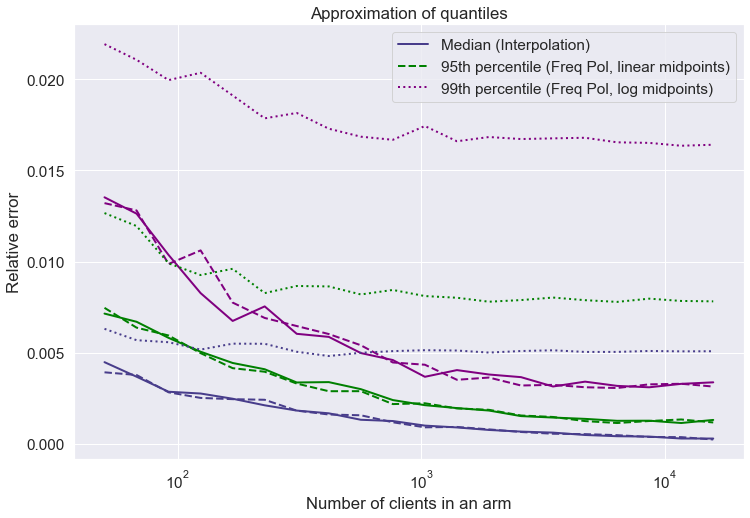

In [166]:
plt.plot(log_number_of_clients, log_approx_error_50_prev, color='darkslateblue',label='Median (Interpolation)')
plt.plot(log_number_of_clients, log_approx_error_95_prev, color='green')
plt.plot(log_number_of_clients, log_approx_error_99_prev, color='purple')
plt.plot(log_number_of_clients, log_approx_error_50_alt, color='darkslateblue',linestyle='dashed')
plt.plot(log_number_of_clients, log_approx_error_95_alt, color='green',linestyle='dashed',label='95th percentile (Freq Pol, linear midpoints)')
plt.plot(log_number_of_clients, log_approx_error_99_alt,color='purple', linestyle='dashed')
plt.plot(log_number_of_clients, log_approx_error_50_alt_log, color='darkslateblue',linestyle='dotted')
plt.plot(log_number_of_clients, log_approx_error_95_alt_log, color='green',linestyle='dotted')
plt.plot(log_number_of_clients, log_approx_error_99_alt_log, color='purple',linestyle='dotted',label='99th percentile (Freq Pol, log midpoints)')
plt.xscale('log')
plt.ylabel('Relative error')
plt.xlabel('Number of clients in an arm')
plt.title('Approximation of quantiles')
plt.legend()
plt.show()

## Remove sign

In [167]:
log_approx_error_50_alt=list()
log_approx_error_95_alt=list()
log_approx_error_99_alt=list()

log_number_of_obs_alt = list()

In [168]:
for cur_number_of_clients in log_number_of_clients:
    cur_med = list()
    cur_95 = list()
    cur_99 = list()
    # number of histogram bins
    num_of_bins=len(bins_boundaries)-1

    # compute tuples of endpoints for each interval for histogram bins
    bins_tuples =  [(bins_boundaries[i-1], bins_boundaries[i]) for i in range(1, num_of_bins+1)]

    # compute midpoints of each bin
    bin_midpoints = [np.mean(bins_tuples[i]) for i in range(num_of_bins)]
    for cur_sim in range(number_of_sims_per_iteration):
        # generate raw data
        raw_data = generate_raw_data(number_of_users =int(cur_number_of_clients))
        log_number_of_obs+=[raw_data.shape[0]]

        # bin raw data
        bucket_data = get_binned_data_cookie_bucket_level(raw_data, number_of_buckets, bins_boundaries)

        # compute cookie buckets for the raw data
        raw_data['Bucket ID'] = (
            raw_data['Client ID'] % number_of_buckets).astype('int')

        # median 
        appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.5) 
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.5)['Metric Value'].values
        cur_med += [(appr_quantiles-exact_quantiles)/exact_quantiles]
        
        # 95th
        appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.95) 
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.95)['Metric Value'].values
        cur_95 += [(appr_quantiles-exact_quantiles)/exact_quantiles]
        
        # 99th
        appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.99)
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.99)['Metric Value'].values
        cur_99 += [(appr_quantiles-exact_quantiles)/exact_quantiles]
    
    log_approx_error_50_alt += [np.mean(cur_med)]
    log_approx_error_95_alt += [np.mean(cur_95)]
    log_approx_error_99_alt += [np.mean(cur_99)]
        
        

In [169]:
log_approx_error_50_prev=list()
log_approx_error_95_prev=list()
log_approx_error_99_prev=list()

log_number_of_obs_prev = list()

In [170]:
# number of histogram bins
num_of_bins=len(bins_boundaries)-1

# compute tuples of endpoints for each interval for histogram bins
bins_tuples =  [(bins_boundaries[i-1], bins_boundaries[i]) for i in range(1, num_of_bins+1)]

# compute midpoints of each bin
bin_midpoints = [np.mean(bins_tuples[i]) for i in range(num_of_bins)]
for cur_number_of_clients in log_number_of_clients:
    cur_med = list()
    cur_95 = list()
    cur_99 = list()
    
    for cur_sim in range(number_of_sims_per_iteration):
        # generate raw data
        raw_data = generate_raw_data(number_of_users =int(cur_number_of_clients))
        log_number_of_obs+=[raw_data.shape[0]]

        # bin raw data
        bucket_data = get_binned_data_cookie_bucket_level(raw_data, number_of_buckets, bins_boundaries)

        # compute cookie buckets for the raw data
        raw_data['Bucket ID'] = (
            raw_data['Client ID'] % number_of_buckets).astype('int')

        # number of histogram bins
        num_of_bins=len(bins_boundaries)-1

        # compute tuples of endpoints for each interval for histogram bins
        bins_tuples = [(bins_boundaries[i-1], bins_boundaries[i]) for i in range(1, num_of_bins+1)]

        # compute midpoints of each bin
        bin_midpoints = [np.mean(bins_tuples[i]) for i in range(num_of_bins)]

        # median 
        appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.5) 
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.5)['Metric Value'].values
        cur_med+= [(appr_quantiles-exact_quantiles)/exact_quantiles]

        # 95th
        appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.95) 
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.95)['Metric Value'].values
        cur_95+= [(appr_quantiles-exact_quantiles)/exact_quantiles]

        # 99th
        appr_quantiles = compute_quantile_hist_data(bucket_data.values, bins_tuples, quantile=0.99)
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.99)['Metric Value'].values
        cur_99+= [(appr_quantiles-exact_quantiles)/exact_quantiles]
    log_approx_error_50_prev += [np.mean(cur_med)]
    log_approx_error_95_prev += [np.mean(cur_95)]
    log_approx_error_99_prev += [np.mean(cur_99)]
    

In [171]:
log_approx_error_50_alt_log=list()
log_approx_error_95_alt_log=list()
log_approx_error_99_alt_log=list()

log_number_of_obs_alt_log = list()

In [172]:
for cur_number_of_clients in log_number_of_clients:
    cur_med = list()
    cur_95 = list()
    cur_99 = list()
    # number of histogram bins
    num_of_bins=len(bins_boundaries)-1

    # compute tuples of endpoints for each interval for histogram bins
    bins_tuples =  [(bins_boundaries[i-1], bins_boundaries[i]) for i in range(1, num_of_bins+1)]

    # compute midpoints of each bin
    bin_midpoints = [np.mean(bins_tuples[i]) for i in range(num_of_bins)]
    for cur_sim in range(number_of_sims_per_iteration):
        # generate raw data
        raw_data = generate_raw_data(number_of_users =int(cur_number_of_clients))
        log_number_of_obs+=[raw_data.shape[0]]

        # bin raw data
        bucket_data = get_binned_data_cookie_bucket_level(raw_data, number_of_buckets, bins_boundaries)

        # compute cookie buckets for the raw data
        raw_data['Bucket ID'] = (
            raw_data['Client ID'] % number_of_buckets).astype('int')

        # median 
        appr_quantiles = alternative_quantile_hist_data(bucket_data.values.ravel(), bins_tuples, quantile=0.5,midpoints_comp='log') 
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.5)['Metric Value'].values
        cur_med += [(appr_quantiles-exact_quantiles)/exact_quantiles]
        
        # 95th
        appr_quantiles = alternative_quantile_hist_data(bucket_data.values.ravel(), bins_tuples, quantile=0.95,midpoints_comp='log') 
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.95)['Metric Value'].values
        cur_95 += [(appr_quantiles-exact_quantiles)/exact_quantiles]
        
        # 99th
        appr_quantiles = alternative_quantile_hist_data(bucket_data.values.ravel(), bins_tuples, quantile=0.99,midpoints_comp='log')
        exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.99)['Metric Value'].values
        cur_99 += [(appr_quantiles-exact_quantiles)/exact_quantiles]
    
    log_approx_error_50_alt_log += [np.mean(cur_med)]
    log_approx_error_95_alt_log += [np.mean(cur_95)]
    log_approx_error_99_alt_log += [np.mean(cur_99)]
        
        

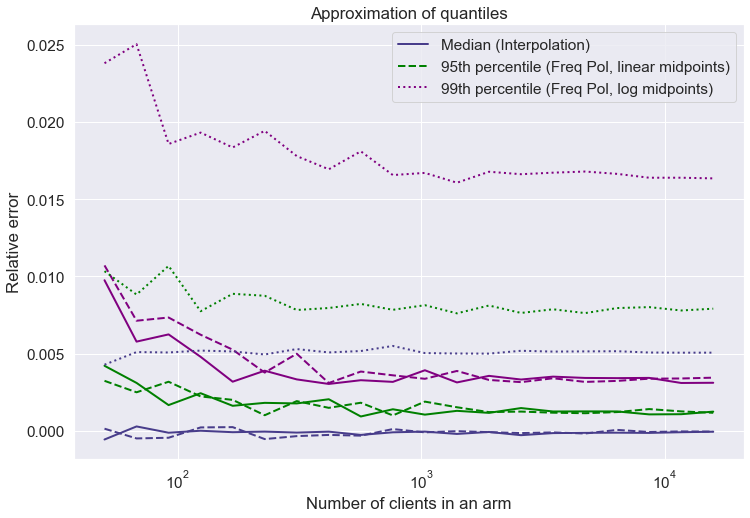

In [173]:
plt.plot(log_number_of_clients, log_approx_error_50_prev, color='darkslateblue',label='Median (Interpolation)')
plt.plot(log_number_of_clients, log_approx_error_95_prev, color='green')
plt.plot(log_number_of_clients, log_approx_error_99_prev, color='purple')
plt.plot(log_number_of_clients, log_approx_error_50_alt, color='darkslateblue',linestyle='dashed')
plt.plot(log_number_of_clients, log_approx_error_95_alt, color='green',linestyle='dashed',label='95th percentile (Freq Pol, linear midpoints)')
plt.plot(log_number_of_clients, log_approx_error_99_alt,color='purple', linestyle='dashed')
plt.plot(log_number_of_clients, log_approx_error_50_alt_log, color='darkslateblue',linestyle='dotted')
plt.plot(log_number_of_clients, log_approx_error_95_alt_log, color='green',linestyle='dotted')
plt.plot(log_number_of_clients, log_approx_error_99_alt_log, color='purple',linestyle='dotted',label='99th percentile (Freq Pol, log midpoints)')
plt.xscale('log')
plt.ylabel('Relative error')
plt.xlabel('Number of clients in an arm')
plt.title('Approximation of quantiles')
plt.legend()
plt.show()

### Lognormal case